<a href="https://colab.research.google.com/github/Dhanushranga1/AIWorks/blob/master/Unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
import zipfile
import shutil
# deep learning libs
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


Unzipping the dataset

In [25]:
zip_path = "/content/drive/MyDrive/kaggle_3m.zip"
extract_path = "/content/kaggle_3m"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("done extracting to:", extract_path)
else:
    print("already extracted, skipping that step")

done extracting to: /content/kaggle_3m


Organizing the images and masks as taken from the kaggle reference

In [28]:
# fixed path that actually contains the patient folders
extract_path = "/content/kaggle_3m/kaggle_3m"

image_dir = "/content/brain_mri/images"
mask_dir = "/content/brain_mri/masks"

os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# only organize if not already done
if not os.listdir(image_dir) or not os.listdir(mask_dir):
    print("organizing image and mask files...")
    for patient in tqdm(os.listdir(extract_path)):
        folder = os.path.join(extract_path, patient)
        if os.path.isdir(folder):
            tifs = glob.glob(os.path.join(folder, "*.tif"))
            for tif in tifs:
                fname = os.path.basename(tif)
                if "_mask" in fname.lower():
                    shutil.copy(tif, os.path.join(mask_dir, fname))
                else:
                    shutil.copy(tif, os.path.join(image_dir, fname))
    print("done.")
    print("images found:", len(os.listdir(image_dir)))
    print("masks found:", len(os.listdir(mask_dir)))
else:
    print("already organized, skipping this step.")


organizing image and mask files...


100%|██████████| 112/112 [00:09<00:00, 11.68it/s]

done.
images found: 3929
masks found: 3929


**Loading the Dataset and PreProcessing the DataSet**

In [29]:
# just resizing everything to 128x128 to keep training light
IMG_SIZE = 128

# this function loads all .tif images + their masks and resizes them
def load_data(img_dir, mask_dir):
    images = sorted(glob.glob(os.path.join(img_dir, "*.tif")))
    masks = sorted(glob.glob(os.path.join(mask_dir, "*.tif")))

    X, Y = [], []
    for img_path, mask_path in tqdm(zip(images, masks), total=len(images)):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        X.append(img)
        Y.append(mask)

    return np.array(X), np.array(Y)


X, Y = load_data("/content/brain_mri/images", "/content/brain_mri/masks")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


100%|██████████| 3929/3929 [00:03<00:00, 1023.31it/s]


**Unet Model**

In [43]:
def unet(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D()(c3)

    # bottleneck
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(b)
    b = layers.BatchNormalization()(b)

    # decoder
    u1 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(u1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(128, 3, activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    u3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(64, 3, activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    # output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    return models.Model(inputs, outputs)


# Compiling model
model = unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

**Training the Model**

In [50]:
history = model.fit(
    X_train, Y_train,
    epochs=20,
    batch_size=8,
    validation_split=0.2  )


Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 56s 179ms/step - accuracy: 0.9917 - loss: 0.0250 - val_accuracy: 0.9879 - val_loss: 0.0344
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 60s 109ms/step - accuracy: 0.9915 - loss: 0.0250 - val_accuracy: 0.9917 - val_loss: 0.0262
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9920 - loss: 0.0237 - val_accuracy: 0.9924 - val_loss: 0.0209
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9921 - loss: 0.0223 - val_accuracy: 0.9925 - val_loss: 0.0197
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9920 - loss: 0.0221 - val_accuracy: 0.9927 - val_loss: 0.0202
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.9919 - loss: 0.0232 - val_accuracy: 0.9922 - val_loss: 0.0221
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9919 - loss: 0.0229 - val_accuracy: 0.9925 - val_loss: 0.0196
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9930 - loss: 0

Segmentation Results Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


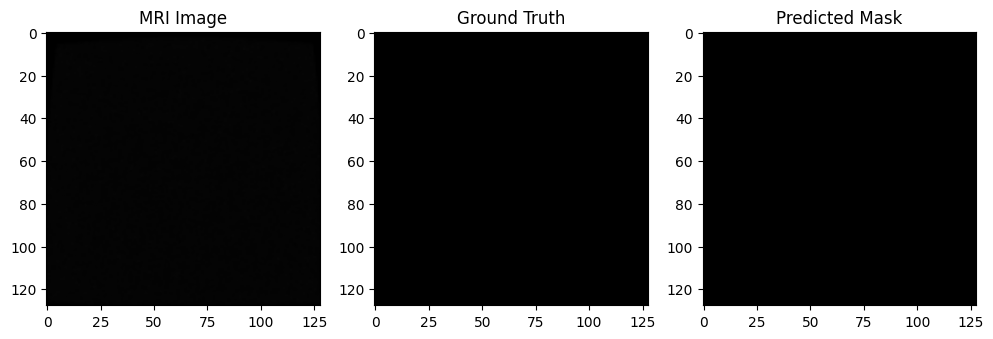

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


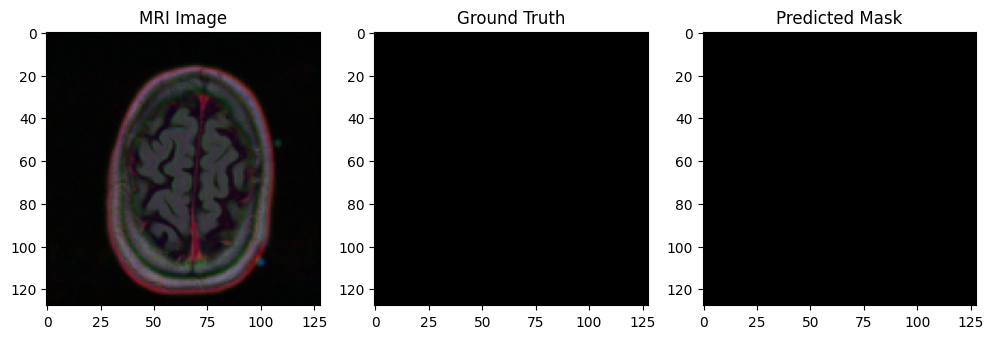

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


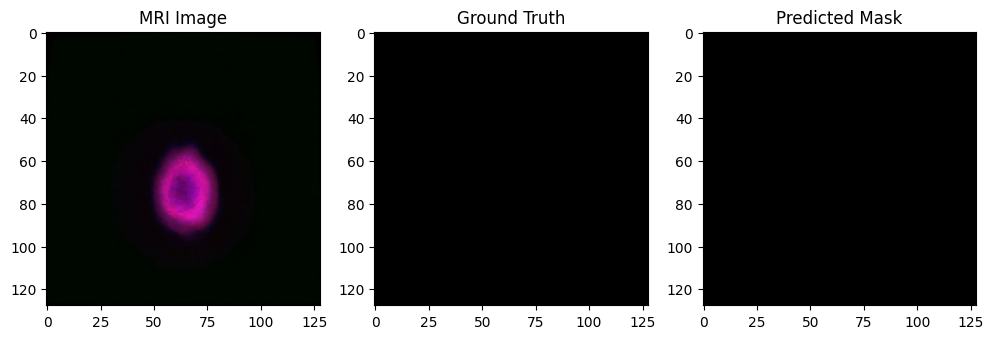

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


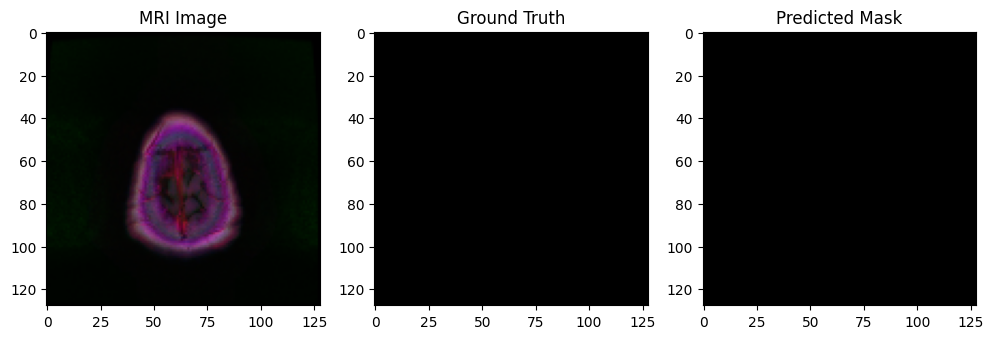

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


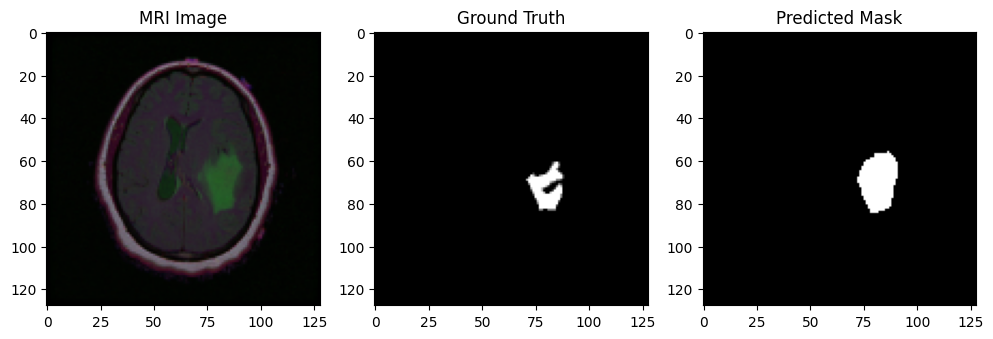

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


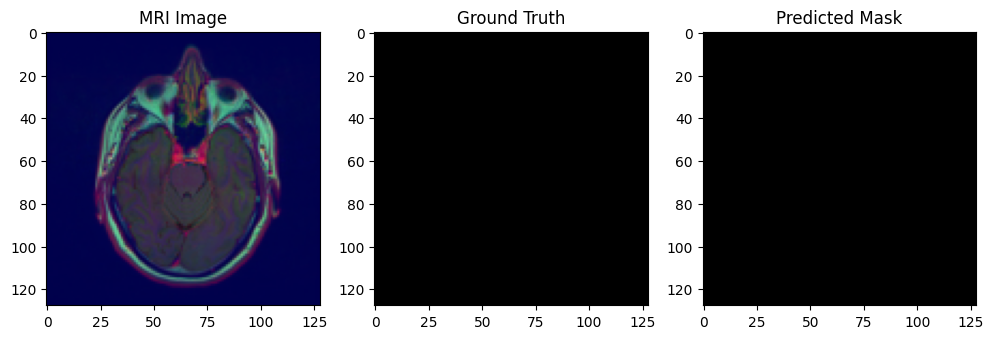

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


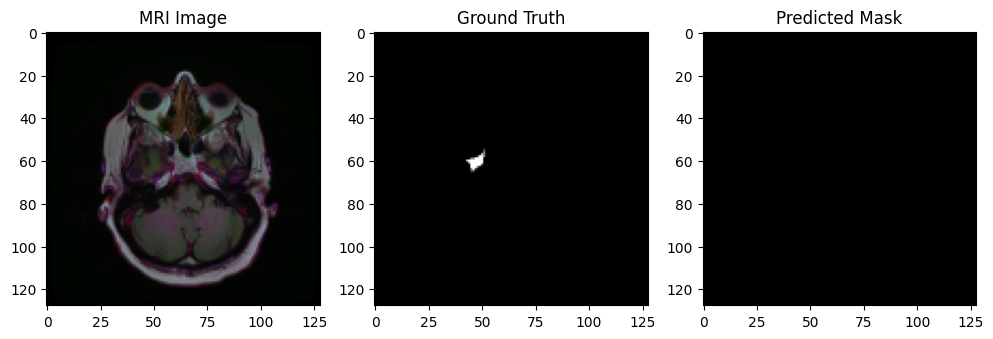

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


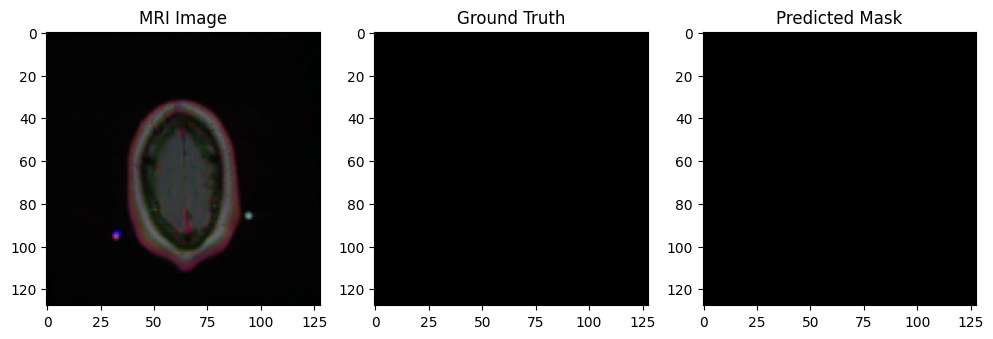

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


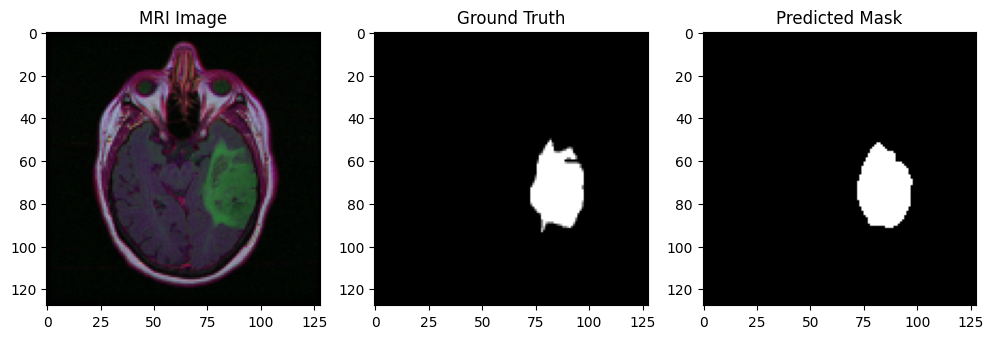

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


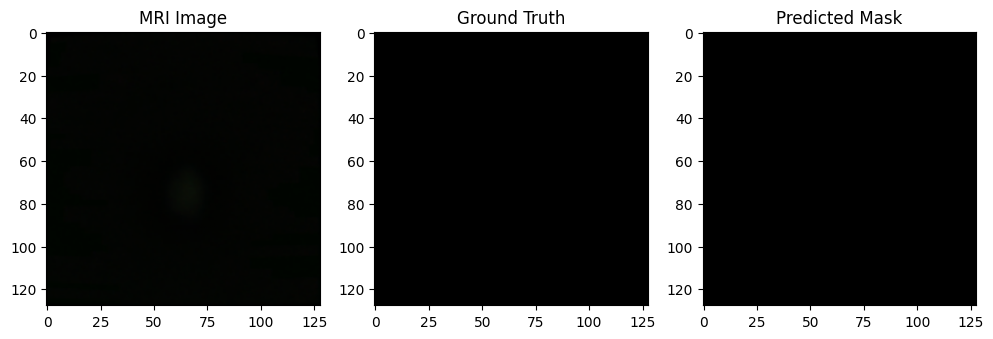

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


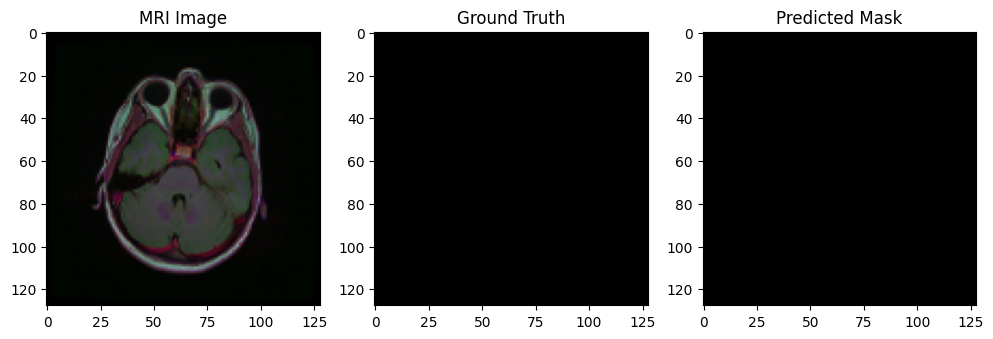

In [52]:
def show_predictions(index):
    image = X_test[index]
    true_mask = Y_test[index].squeeze()

    # prediction
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()
    pred_mask_bin = pred_mask > 0.5

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("MRI Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(true_mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask_bin, cmap="gray")
    plt.show()


show_predictions(2)
show_predictions(3)
show_predictions(4)
show_predictions(5)
show_predictions(8)
show_predictions(9)
show_predictions(10)
show_predictions(11)
show_predictions(12)
show_predictions(13)
show_predictions(14)


**IoU and Dice Score Evaluation**

In [53]:
print("Y_test shape:", Y_test.shape)
print("y_preds shape:", y_preds.shape)


Y_test shape: (786, 128, 128, 1)
y_preds shape: (786, 128, 128, 1)


In [61]:
# Predict on full test set
y_preds = model.predict(X_test, batch_size=8)

# Now compute metrics
iou_score = iou(Y_test, y_preds).numpy()
dice_score = dice_coef(Y_test, y_preds).numpy()

print("IoU Score:", iou_score)
print("Dice Coefficient:", dice_score)


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
IoU Score: 0.49034584
Dice Coefficient: 0.6580296


In [62]:
def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)
iou_score = iou(Y_test, y_preds).numpy()
dice_score = dice_coef(Y_test, y_preds).numpy()

print("IoU Score:", iou_score)
print("Dice Coefficient:", dice_score)


IoU Score: 0.49034584
Dice Coefficient: 0.6580296


**Loss And Accuracy Plots**

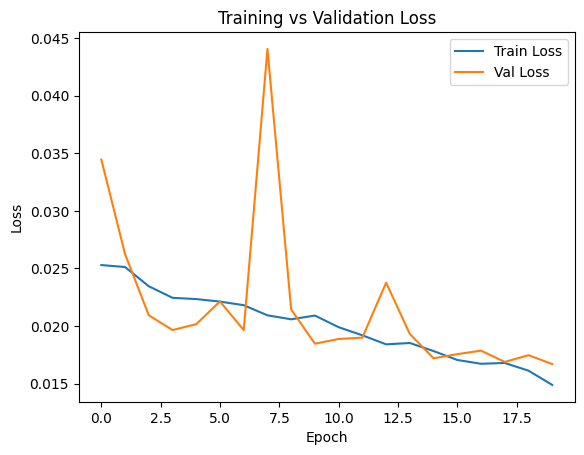

In [51]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [56]:
model.save("unet_brain_mri_model.h5")
print("Model saved!")


Model saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


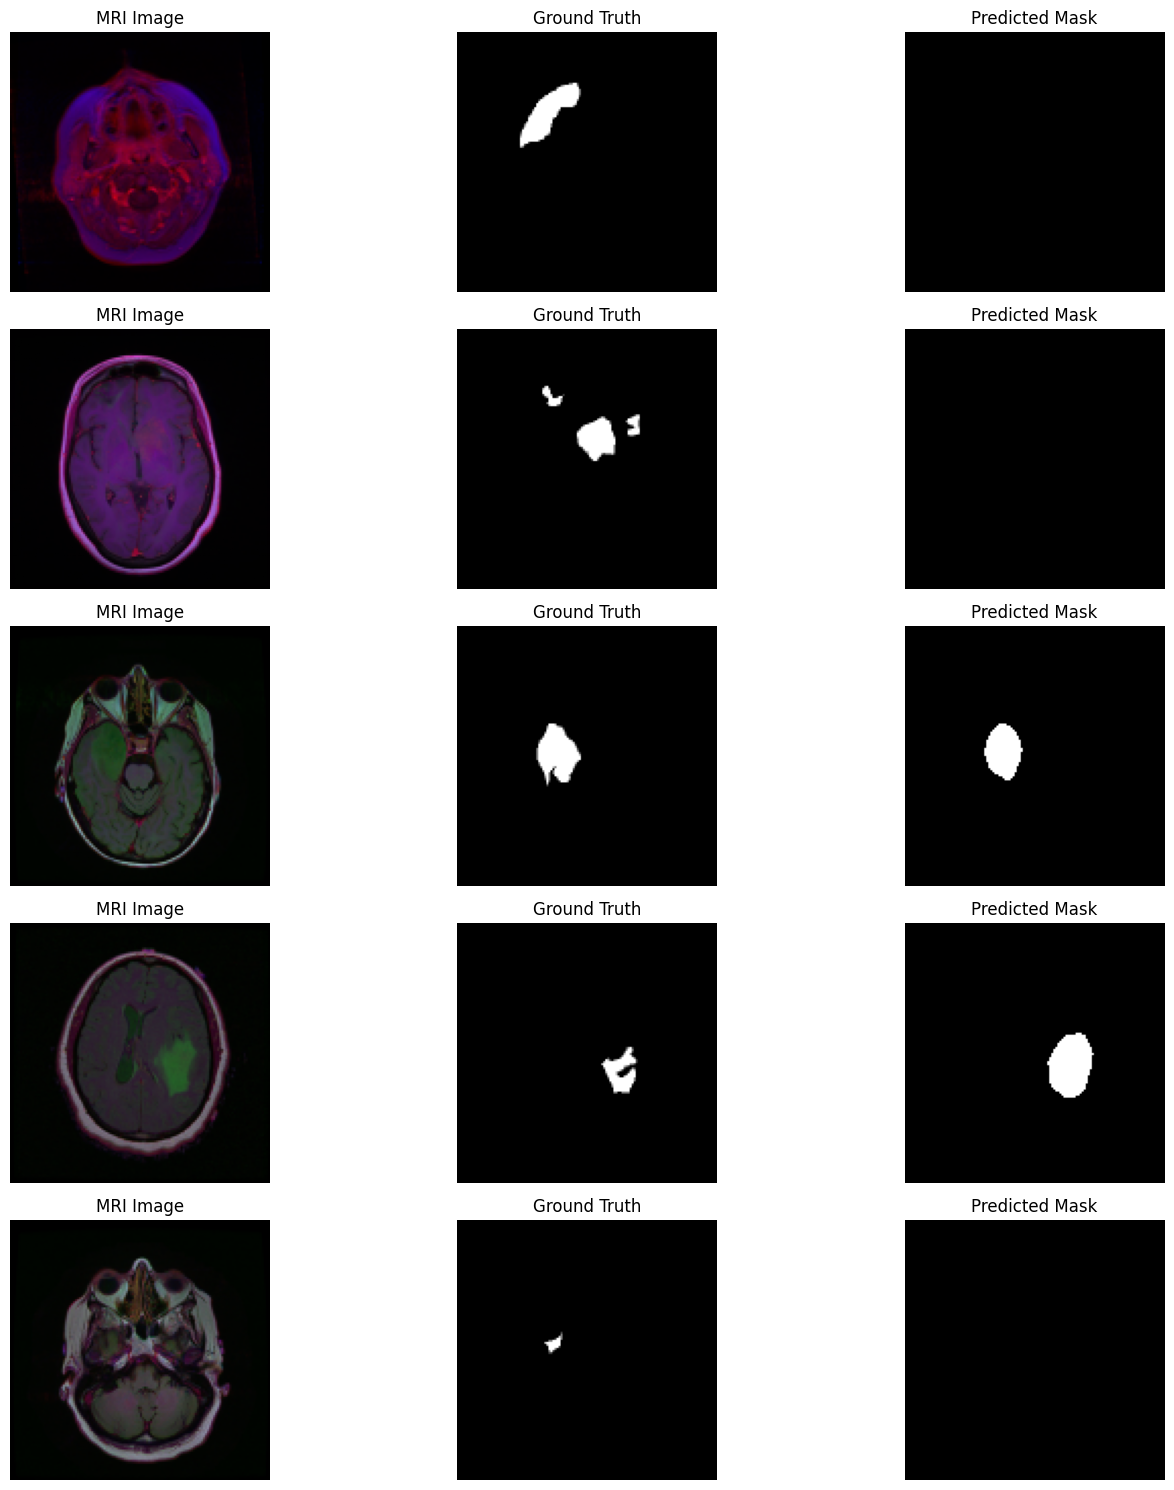

In [60]:
def show_relevant_predictions(n=5):
    shown = 0
    i = 0
    plt.figure(figsize=(15, n * 3))
    while shown < n and i < len(X_test):
        true_mask = Y_test[i].squeeze()
        if true_mask.sum() > 0:
            image = X_test[i]
            pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()
            pred_mask_bin = pred_mask > 0.2

            plt.subplot(n, 3, shown * 3 + 1)
            plt.imshow(image)
            plt.title("MRI Image")
            plt.axis('off')

            plt.subplot(n, 3, shown * 3 + 2)
            plt.imshow(true_mask, cmap="gray")
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(n, 3, shown * 3 + 3)
            plt.imshow(pred_mask_bin, cmap="gray")
            plt.title("Predicted Mask")
            plt.axis('off')

            shown += 1
        i += 1
    plt.tight_layout()
    plt.show()

show_relevant_predictions(5)
